 # Clustering Notebook
 
 Salient Features:
 
 - Mosaic: Geomedian (recently added to dc_mosaic.py)
 - Clustering: K-Means and Birch (recently added to utils/dc_clustering.py)
 - Bands: User selects band(s) to cluster
 - Visualize and Export: Geomedian mosaic and cluster output to geotiff
 - Data: Landsat8 with pixel_qa
 

# Loading the data

> **Data cube object**  
> A datacube object is your interface with data stored on your data cube system.  
<br>  

In [1]:
import datacube
dc = datacube.Datacube(config='/home/localuser/.datacube.conf')

> **Listing available products**  
> Lookup product/platform name to load in your data.
<br>  

In [2]:
product_listing = dc.list_products()
product_listing[product_listing["name"].str.contains('samoa')]

,name,description,lat,gsi,time,format,sat_path,sat_row,platform,lon,product_type,orbit,instrument,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,


> **Inspection Results**  
> Note the name and platform from the above table and initialize the product and platform respectively in the next block
<br>


# Inspect the metadata available for Vietnam in the Data Cube

In [3]:
#from utils.data_access_api import DataAccessApi
from utils.data_cube_utilities.data_access_api import DataAccessApi

api = DataAccessApi(config='/home/localuser/.datacube.conf')

product = "ls7_ledaps_vietnam"
platform = "LANDSAT_7"

api.get_datacube_metadata(platform=platform,product=product)

{'lat_extents': (9.1762906272858, 13.964939912344285),
 'lon_extents': (102.4041694654867, 108.9310588253174),
 'pixel_count': 430347411,
 'tile_count': 692,
 'time_extents': (datetime.datetime(1999, 9, 8, 3, 13, 19),
  datetime.datetime(2016, 12, 29, 3, 10))}

# Area of Interest [Vietnam] 

In [4]:
# Picking a small area due to memory limitations
area_extent = {'latitude': (10.9, 11.00),'longitude': (107.8, 107.9)} 
# area_extent = {'latitude': (11.10, 11.39),'longitude': (106.8, 106.92)} 

# Visualize Area

In [5]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude  = area_extent['latitude'],
            longitude = area_extent['longitude'])

### Narrow down time range

In [6]:
from datetime import datetime 
date_range = (datetime(2010,1,1), datetime(2011,1,1))

### Load product

In [7]:
parameters = dict(measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                  time = date_range,
                  platform = platform,
                  product =  product,
                  **area_extent)


dataset = dc.load(**parameters)

In [8]:
dataset

<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-11T02:59:07 2010-01-27T02:59:20 ...
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 ...
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 107.8 107.8 107.8 ...
Data variables:
    red        (time, latitude, longitude) int16 1984 2004 1984 1861 1779 ...
    green      (time, latitude, longitude) int16 1971 1994 1994 1860 1793 ...
    blue       (time, latitude, longitude) int16 2068 2068 2026 1877 1770 ...
    nir        (time, latitude, longitude) int16 3390 3390 3390 3254 3208 ...
    swir1      (time, latitude, longitude) int16 2263 2318 2318 2128 1994 ...
    swir2      (time, latitude, longitude) int16 1547 1689 1717 1574 1404 ...
    pixel_qa   (time, latitude, longitude) int32 224 224 224 224 224 224 224 ...
Attributes:
    crs:      EPSG:4326

## Create Geographic Chunks (For efficient processing)

In [9]:
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks

geographic_chunks = create_geographic_chunks(
                                latitude=area_extent['latitude'], 
                                longitude=area_extent['longitude'], 
                                geographic_chunk_size=.05)
geographic_chunks

[{'latitude': (10.9, 11.0), 'longitude': (107.8, 107.9)}]

## Create a GeoMedian Mosaic

In [10]:
import xarray as xr  
import numpy as np
import utils.data_cube_utilities.dc_mosaic as dc_mosaic
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
import importlib
importlib.reload(dc_mosaic)

measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']
product_chunks = []

for index, chunk in enumerate(geographic_chunks):
    data = dc.load(measurements = measurements,
                   time = date_range,
                   platform = platform,
                   product =  product,
                   longitude=chunk['longitude'],
                   latitude=chunk['latitude'])
    # Mask out clouds and scan lines.
    clean_mask = landsat_qa_clean_mask(data, platform)
    # Create the mosaic.
    product_chunks.append(dc_mosaic.create_hdmedians_multiple_band_mosaic(data, clean_mask=clean_mask, dtype=np.float32))

## Combine the chunks to produce the final mosaic

In [11]:
print(product_chunks)

[<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372)
Coordinates:
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 107.8 107.8 107.8 ...
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 ...
Data variables:
    blue       (latitude, longitude) float64 227.6 231.3 218.2 220.2 270.5 ...
    swir2      (latitude, longitude) float64 569.9 570.6 533.9 497.8 596.7 ...
    nir        (latitude, longitude) float64 2.871e+03 2.956e+03 2.681e+03 ...
    pixel_qa   (latitude, longitude) float64 66.0 66.0 66.0 66.0 66.0 66.0 ...
    swir1      (latitude, longitude) float64 1.372e+03 1.446e+03 1.347e+03 ...
    green      (latitude, longitude) float64 365.4 395.1 357.5 365.9 449.1 ...
    red        (latitude, longitude) float64 281.8 291.0 251.1 241.8 333.3 ...
Attributes:
    crs:      EPSG:4326]


In [12]:
import utils.data_cube_utilities.dc_chunker as dc_chunker
import importlib
importlib.reload(dc_chunker)
final_mosaic = dc_chunker.combine_geographic_chunks(product_chunks)
final_mosaic

<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372)
Coordinates:
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 ...
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 107.8 107.8 107.8 ...
Data variables:
    blue       (latitude, longitude) float64 227.6 231.3 218.2 220.2 270.5 ...
    swir2      (latitude, longitude) float64 569.9 570.6 533.9 497.8 596.7 ...
    nir        (latitude, longitude) float64 2.871e+03 2.956e+03 2.681e+03 ...
    pixel_qa   (latitude, longitude) float64 66.0 66.0 66.0 66.0 66.0 66.0 ...
    swir1      (latitude, longitude) float64 1.372e+03 1.446e+03 1.347e+03 ...
    green      (latitude, longitude) float64 365.4 395.1 357.5 365.9 449.1 ...
    red        (latitude, longitude) float64 281.8 291.0 251.1 241.8 333.3 ...
Attributes:
    crs:      EPSG:4326

## Export Mosaic Geotiff 

In [13]:
import utils.data_cube_utilities.dc_utilities as dc_utilities
# from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr
import importlib
importlib.reload(dc_utilities)
output_mosaic_file_name  =  "cluster_mosaic.tif"

dc_utilities.write_geotiff_from_xr(output_mosaic_file_name, final_mosaic, measurements, nodata=-9999)

## Take a look at the Mosaic

In [14]:
def figure_ratio(ds, fixed_width = 15):
    width = fixed_width
    height = len(ds.latitude) * (fixed_width / len(ds.longitude))
    return (width, height)

> ### Example of composited bands

> #### True color 

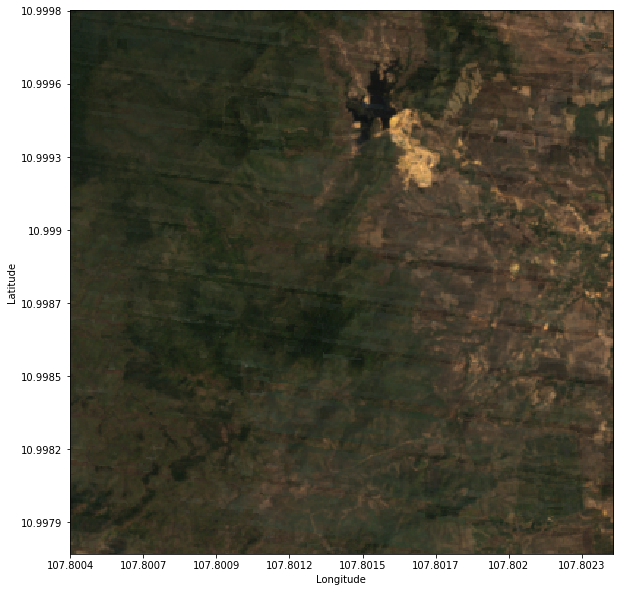

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from dc_notebook_utilities import rgb
rgb(final_mosaic,
    bands = ['red','green','blue'])

> ### False color 

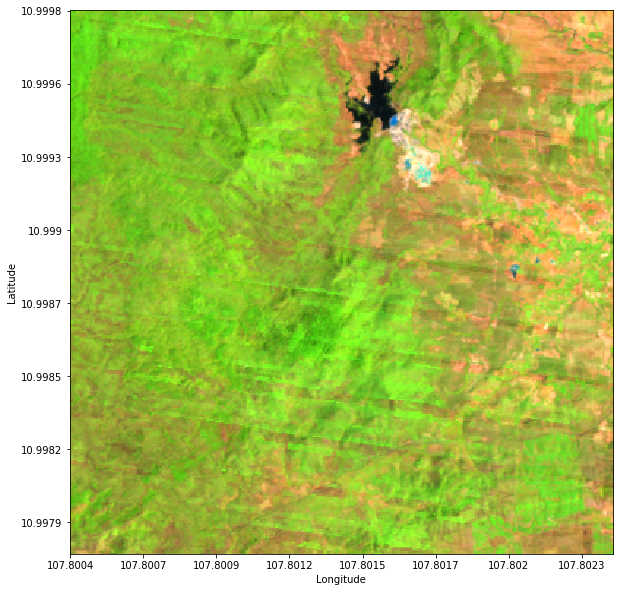

In [16]:
rgb(final_mosaic,
    bands = ['swir1','nir','red'])

> ### Example of a composited `swir1` band

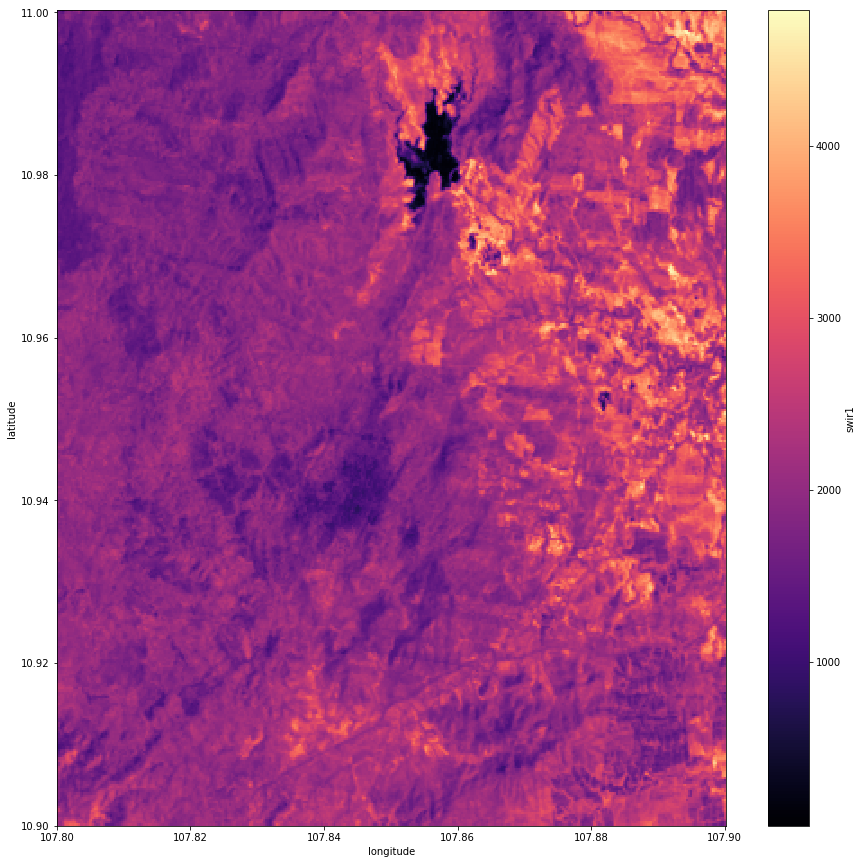

In [17]:
final_mosaic.swir1.plot(figsize = figure_ratio(final_mosaic), cmap = 'magma')

## Bands used for clustering

In [18]:
cluster_bands = ['red', 'green', 'blue', 'swir1']

# Perform K-Means Clustering

In [19]:
from utils.data_cube_utilities.dc_clustering import kmeans_cluster_dataset, get_frequency_counts

classification_4 =  kmeans_cluster_dataset(final_mosaic, cluster_bands, n_clusters=4)
freq_counts_4 =     get_frequency_counts(classification_4)
classification_8 =  kmeans_cluster_dataset(final_mosaic, cluster_bands, n_clusters=8)
freq_counts_8 =     get_frequency_counts(classification_8)
classification_12 = kmeans_cluster_dataset(final_mosaic, cluster_bands, n_clusters=12)
freq_counts_12 =    get_frequency_counts(classification_12)

## Visualize the clusters

There were 12764 data points in class 2, comprising 9.22% of all data points.
There were 30454 data points in class 0, comprising 22.01% of all data points.
There were 32572 data points in class 3, comprising 23.54% of all data points.
There were 62594 data points in class 1, comprising 45.23% of all data points.


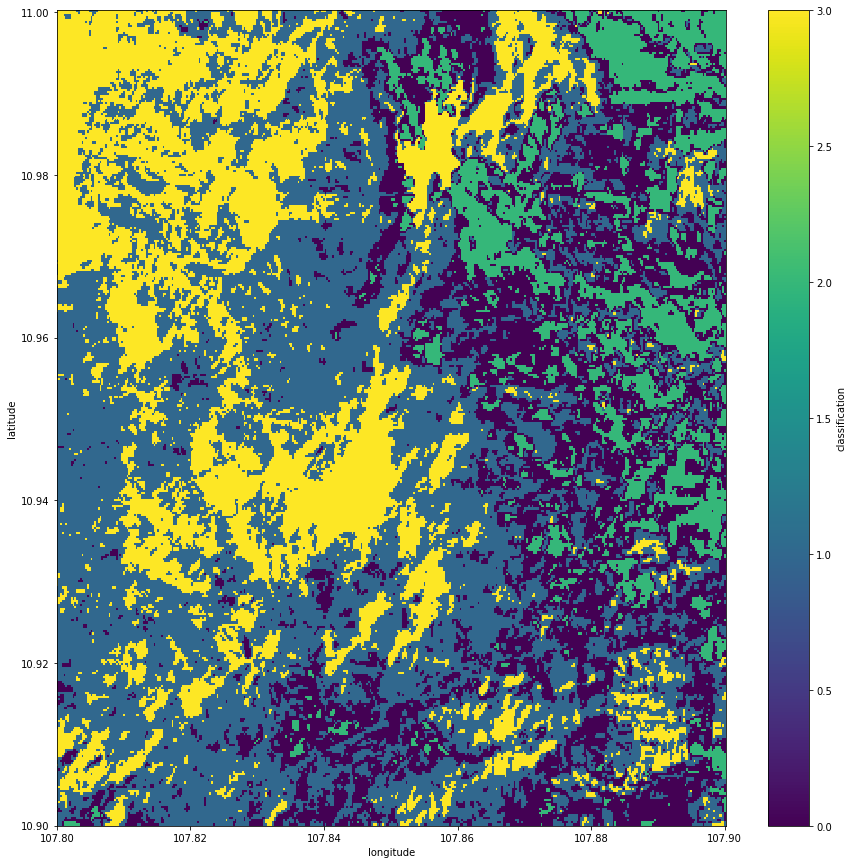

In [20]:
for class_num, (freq, fractional_freq) in freq_counts_4:
    print("There were {} data points in class {}, comprising {:.2%} of all data points.".format(freq, class_num, fractional_freq))
classification_4.classification.plot(figsize = figure_ratio(classification_4))
plt.show()

There were 726 data points in class 7, comprising 0.52% of all data points.
There were 1042 data points in class 4, comprising 0.75% of all data points.
There were 7064 data points in class 3, comprising 5.10% of all data points.
There were 13237 data points in class 5, comprising 9.57% of all data points.
There were 15506 data points in class 0, comprising 11.21% of all data points.
There were 23306 data points in class 1, comprising 16.84% of all data points.
There were 38086 data points in class 2, comprising 27.52% of all data points.
There were 39417 data points in class 6, comprising 28.48% of all data points.


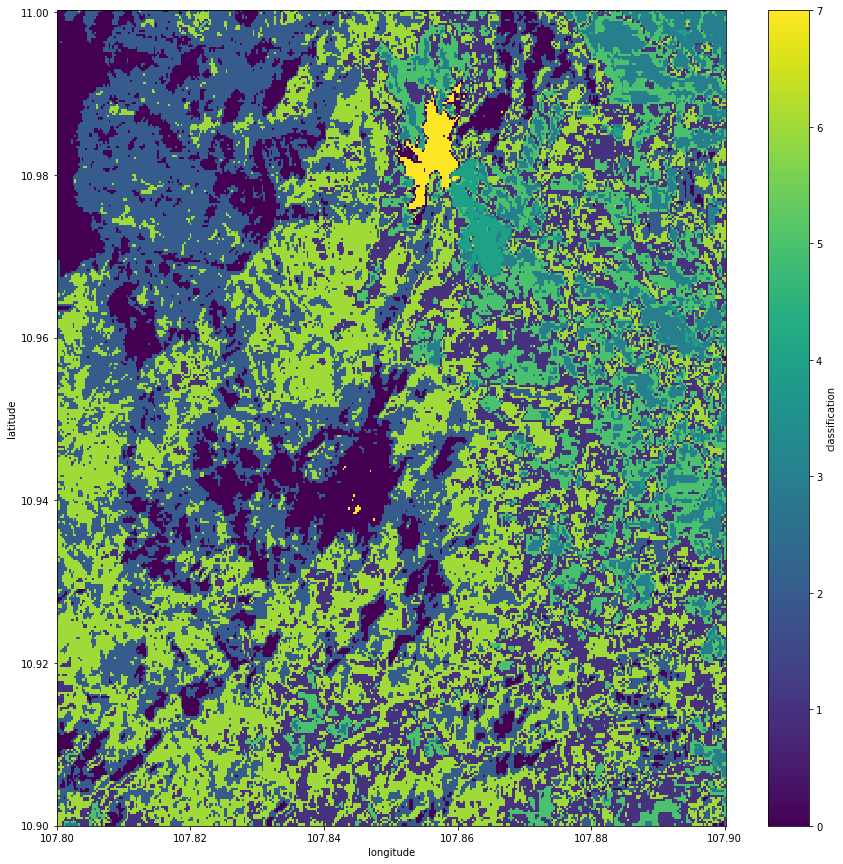

In [21]:
for class_num, (freq, fractional_freq) in freq_counts_8:
    print("There were {} data points in class {}, comprising {:.2%} of all data points.".format(freq, class_num, fractional_freq))
classification_8.classification.plot(figsize = figure_ratio(classification_8))
plt.show()

There were 255 data points in class 11, comprising 0.18% of all data points.
There were 691 data points in class 9, comprising 0.50% of all data points.
There were 704 data points in class 8, comprising 0.51% of all data points.
There were 2428 data points in class 4, comprising 1.75% of all data points.
There were 6616 data points in class 5, comprising 4.78% of all data points.
There were 8890 data points in class 3, comprising 6.42% of all data points.
There were 8936 data points in class 1, comprising 6.46% of all data points.
There were 13337 data points in class 2, comprising 9.64% of all data points.
There were 19823 data points in class 7, comprising 14.32% of all data points.
There were 20129 data points in class 10, comprising 14.55% of all data points.
There were 27987 data points in class 0, comprising 20.22% of all data points.
There were 28588 data points in class 6, comprising 20.66% of all data points.


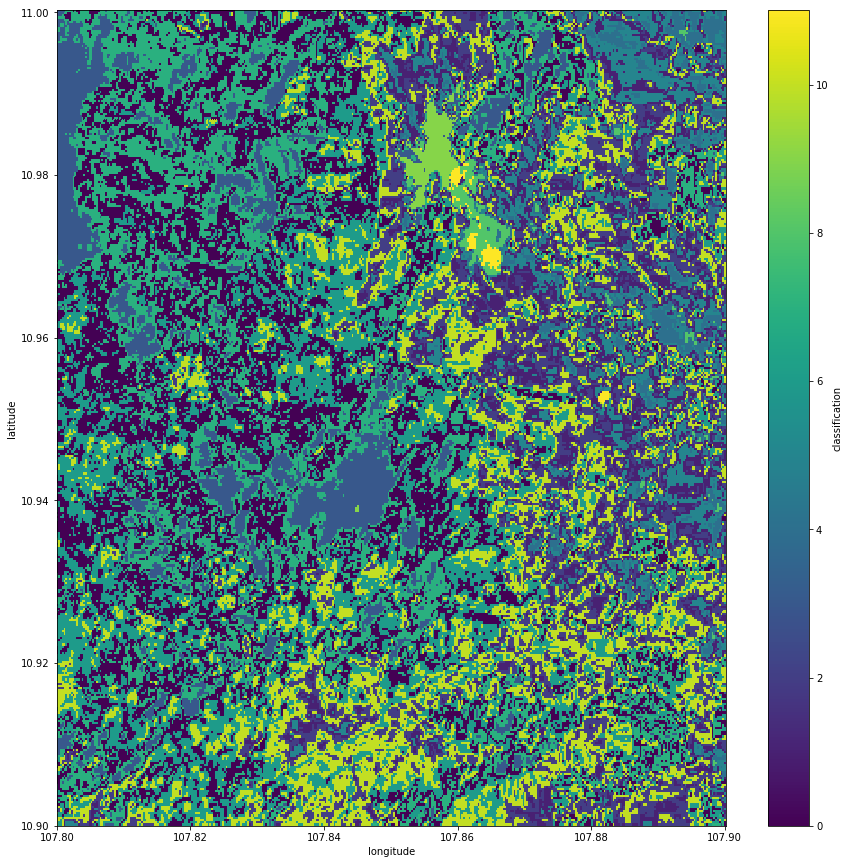

In [22]:
for class_num, (freq, fractional_freq) in freq_counts_12:
    print("There were {} data points in class {}, comprising {:.2%} of all data points.".format(freq, class_num, fractional_freq))
classification_12.classification.plot(figsize = figure_ratio(classification_12))
plt.show()

## Export the output (K-Means Clusters)

In [23]:
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr

output_kmeans_cluster4_file_name  =  "cluster4_kmeans.tif"
output_kmeans_cluster8_file_name  =  "cluster8_kmeans.tif"
output_kmeans_cluster12_file_name  =  "cluster12_kmeans.tif"

write_geotiff_from_xr(output_kmeans_cluster4_file_name, classification_4, ['classification'], nodata=-9999)
write_geotiff_from_xr(output_kmeans_cluster8_file_name, classification_8, ['classification'], nodata=-9999)
write_geotiff_from_xr(output_kmeans_cluster12_file_name, classification_12, ['classification'], nodata=-9999)